Tutorial 2: Aggregator
======================

In the previous tutorial, we fitted 3 datasets with an identical `NonLinearSearch`, outputting the results of each to a
unique folder on our hard disk.

In this tutorial, we'll use the `Aggregator` to load the `Result`'s and manipulate them using our Jupyter
notebook. The API for using a `Result` is described fully in tutorial 6 of chapter 1 of **HowToFit**.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


First, note how the results are not contained in the `output` folder after each search completes. Instead, they are
contained in the `database_howtofit.sqlite` file, which we can load using the `Aggregator`.

In [2]:
agg = af.Aggregator.from_database(
    path.join("output", "database_howtofit.sqlite")
)

Before using the aggregator to inspect results, let me quickly cover Python generators. A generator is an object that 
iterates over a function when it is called. The aggregator creates all of the objects that it loads from the database 
as generators (as opposed to a list, or dictionary, or other Python type).

Why? Because lists and dictionaries store every entry in memory simultaneously. If you fit many datasets, this will use 
a lot of memory and crash your laptop! On the other hand, a generator only stores the object in memory when it is used; 
Python is then free to overwrite it afterwards. Thus, your laptop won't crash!

There are two things to bare in mind with generators:

1) A generator has no length and to determine how many entries it contains you first must turn it into a list.

2) Once we use a generator, we cannot use it again and need to remake it. For this reason, we typically avoid 
 storing the generator as a variable and instead use the aggregator to create them on use.

We can now create a `samples` generator of every fit. As we saw in the `result.py` example scripts, an instance of 
the `Samples` class acts as an interface to the results of the non-linear search.

In [3]:
samples_gen = agg.values("samples")

When we print this list of outputs you should see over 3 different `NestSamples` instances, corresponding to the 3
model-fits we performed in the previous tutorial.

In [4]:
print("Emcee Samples:\n")
print(samples_gen)
print("Total Samples Objects = ", len(list(samples_gen)), "\n")

Emcee Samples:

[<autofit.non_linear.nest.dynesty.DynestySamples object at 0x7f07590bd700>, <autofit.non_linear.nest.dynesty.DynestySamples object at 0x7f074d814ca0>, <autofit.non_linear.nest.dynesty.DynestySamples object at 0x7f074d7b7070>]
Total Samples Objects =  3 



We've encountered the `Samples` class in previous tutorials. As we saw in chapter 1, the `Samples` class contains all 
the accepted parameter samples of the `NonLinearSearch`, which is a list of lists where:

 - The outer list is the size of the total number of samples.
 - The inner list is the size of the number of free parameters in the fit.

With the `Aggregator` we can now get information on the `Samples` of all 3 model-fits, as opposed to just 1 fit using 
its `Result` object.

In [5]:
for samples in agg.values("samples"):
    print("All parameters of the very first sample")
    print(samples.parameter_lists[0])
    print("The tenth sample`s third parameter")
    print(samples.parameter_lists[9][2])
    print()

All parameters of the very first sample
[36.84924790106425, 88.61405963592635, 12.233001908814078]
The tenth sample`s third parameter
5.034953669402292

All parameters of the very first sample
[3.413276724386216, 81.04569353441282, 4.955933939647583]
The tenth sample`s third parameter
19.136945913191713

All parameters of the very first sample
[73.52289291936378, 68.55836591210458, 8.543967207428743]
The tenth sample`s third parameter
5.6366431651051725



We can use the `Aggregator` to get information on the `log_likelihood_list`, log_prior_list`, `weight_list`, etc. of every fit.

In [6]:
for samples in agg.values("samples"):
    print("log(likelihood), log(prior), log(posterior) and weight of the tenth sample.")
    print(samples.log_likelihood_list[9])
    print(samples.log_prior_list[9])
    print(samples.log_posterior_list[9])
    print(samples.weight_list[9])
    print()

log(likelihood), log(prior), log(posterior) and weight of the tenth sample.
-12190.099272381121
0.5707731752619661
-12189.528499205859
0.0

log(likelihood), log(prior), log(posterior) and weight of the tenth sample.
-6302.971835464521
1.706897963375157
-6301.264937501146
0.0

log(likelihood), log(prior), log(posterior) and weight of the tenth sample.
-57583.08458442775
0.45312848340482015
-57582.63145594434
0.0



We can use the `Sample`'s to create a list of the `max_log_likelihood_vector` of each fit to our three images.

In [7]:
vector = [samps.max_log_likelihood_vector for samps in agg.values("samples")]
print("Maximum Log Likelihood Parameter Lists:\n")
print(vector, "\n")

Maximum Log Likelihood Parameter Lists:

[[49.95701332619952, 24.708625099691133, 4.962061899746135], [50.033899327147545, 24.60400912412349, 9.960214563402404], [49.99577420273339, 25.007511431838505, 0.9986827646170955]] 



As discussed in chapter 1, vectors are not ideal because we can`t be sure which values correspond to which parameters.

We can use the `Aggregator` to create the `max_log_likelihood_instance` of every fit.

In [8]:
instances = [samps.max_log_likelihood_instance for samps in agg.values("samples")]
print("Maximum Log Likelihood Model Instances:\n")
print(instances, "\n")

Maximum Log Likelihood Model Instances:

[<autofit.mapper.model.ModelInstance object at 0x7f074d427a30>, <autofit.mapper.model.ModelInstance object at 0x7f074d442b20>, <autofit.mapper.model.ModelInstance object at 0x7f074d8c6f10>] 



The model instance contains all the model components of our fit which for the fits above was a single `Gaussian`
profile (the word `gaussian` comes from what we called it in the `Collection` above).

In [9]:
print(instances[0].gaussian)
print(instances[1].gaussian)
print(instances[2].gaussian)

This, of course, gives us access to any individual parameter of our maximum log likelihood `instance`. Below, we see 
that the 3 `Gaussian`s were simulated using `sigma` values of 1.0, 5.0 and 10.0.

In [10]:
print(instances[0].gaussian.sigma)
print(instances[1].gaussian.sigma)
print(instances[2].gaussian.sigma)

4.962061899746135
9.960214563402404
0.9986827646170955


We can also access the `median_pdf` model via the `Aggregator`, as we saw for the `Samples` object in chapter 1.

In [11]:
mp_vectors = [samps.median_pdf_vector for samps in agg.values("samples")]
mp_instances = [samps.median_pdf_instance for samps in agg.values("samples")]

print("Median PDF Model Parameter Lists:\n")
print(mp_vectors, "\n")
print("Most probable Model Instances:\n")
print(mp_instances, "\n")

Median PDF Model Parameter Lists:

[[49.9647491897095, 24.725240483538244, 4.969170457966852], [50.01586974668783, 24.591410683831093, 9.962087290315111], [49.99600046412087, 25.013128828427792, 0.9991830923435702]] 

Most probable Model Instances:

[<autofit.mapper.model.ModelInstance object at 0x7f074d399940>, <autofit.mapper.model.ModelInstance object at 0x7f074d4d9ca0>, <autofit.mapper.model.ModelInstance object at 0x7f074d3995e0>] 



We can also print the `model_results` of all searchs, which is string that summarizes every fit`s model providing
quick inspection of all results.

In [12]:
results = agg.model_results
print("Model Results Summary:\n")
print(results, "\n")

Model Results Summary:

o.id IN (SELECT parent_id FROM object AS o WHERE o.name = 'model_results') 



Lets end the tutorial with something more ambitious. Lets create a plot of the inferred `sigma` values vs `intensity` 
of each `Gaussian` profile, including error bars at $3\sigma$ confidence.

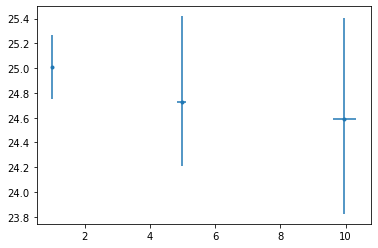

In [13]:
import matplotlib.pyplot as plt

mp_instances = [samps.median_pdf_instance for samps in agg.values("samples")]
ue3_instances = [
    samp.error_instance_at_upper_sigma(sigma=3.0) for samp in agg.values("samples")
]
le3_instances = [
    samp.error_instance_at_lower_sigma(sigma=3.0) for samp in agg.values("samples")
]

mp_sigmas = [instance.gaussian.sigma for instance in mp_instances]
ue3_sigmas = [instance.gaussian.sigma for instance in ue3_instances]
le3_sigmas = [instance.gaussian.sigma for instance in le3_instances]
mp_intensitys = [instance.gaussian.intensity for instance in mp_instances]
ue3_intensitys = [instance.gaussian.intensity for instance in ue3_instances]
le3_intensitys = [instance.gaussian.intensity for instance in le3_instances]

plt.errorbar(
    x=mp_sigmas,
    y=mp_intensitys,
    marker=".",
    linestyle="",
    xerr=[le3_sigmas, ue3_sigmas],
    yerr=[le3_intensitys, ue3_intensitys],
)
plt.show()

With that, tutorial 2 is complete. 

The take home point of this tutorial is that everything that is available in a `Result` or `Samples` object is 
accessible via the `Aggregator`. 